In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Set plot style and figure size
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [3]:
# Load datasets
try:
    # Try to load the preprocessed and raw datasets
    clean_df = pd.read_csv("../Data/Preprocessed_Manual_Labelled_Dataset .csv")
    print("Successfully loaded cleaned dataset")
except FileNotFoundError:
    print("Clean dataset file not found, please check the path")
    clean_df = None

try:
    raw_df = pd.read_csv("../Data/raw_Dataset.csv")
    print("Successfully loaded raw dataset")
except FileNotFoundError:
    print("Raw dataset file not found, please check the path")
    # Try an alternative name
    try:
        raw_df = pd.read_csv("Data/Raw_Manual_Labelled_Dataset.csv")
        print("Successfully loaded raw dataset with alternative name")
    except FileNotFoundError:
        print("Alternative raw dataset file not found, please check the path")
        raw_df = None

Successfully loaded cleaned dataset
Successfully loaded raw dataset


In [4]:
# --------------------------------
# General dataset information
# --------------------------------

def display_general_info(df, title):
    """Display general information about the dataset"""
    print(f"\n{'-'*50}")
    print(f"{title}")
    print(f"{'-'*50}")
    
    if df is None:
        print("Dataset not available for analysis")
        return
    
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {', '.join(df.columns)}")
    
    # Check for null values
    null_counts = df.isnull().sum()
    print("\nNull values count:")
    print(null_counts[null_counts > 0] if any(null_counts > 0) else "No null values found")
    
    # Basic statistics for any numeric columns
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns
    if len(numeric_cols) > 0:
        print("\nBasic statistics for numeric columns:")
        print(df[numeric_cols].describe())

# Display general info for both datasets
display_general_info(clean_df, "CLEAN DATASET INFO")
display_general_info(raw_df, "RAW DATASET INFO")


--------------------------------------------------
CLEAN DATASET INFO
--------------------------------------------------
Dataset shape: (2617, 4)
Columns: raw_text, label, cleaned_text, cleaned_tokens

Null values count:
No null values found

--------------------------------------------------
RAW DATASET INFO
--------------------------------------------------
Dataset shape: (2653, 2)
Columns: raw_text, label

Null values count:
No null values found



--------------------------------------------------
CLEAN DATASET
--------------------------------------------------
Class distribution:
label
Normal        1019
Depression     800
Anxiety        798
Name: count, dtype: int64

Percentage distribution:
Normal: 38.94%
Depression: 30.57%
Anxiety: 30.49%


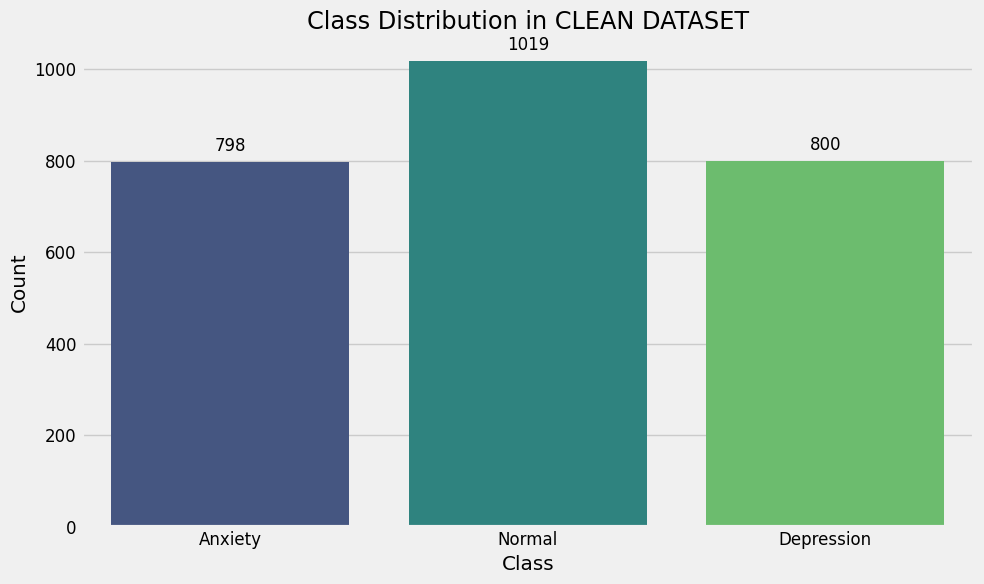

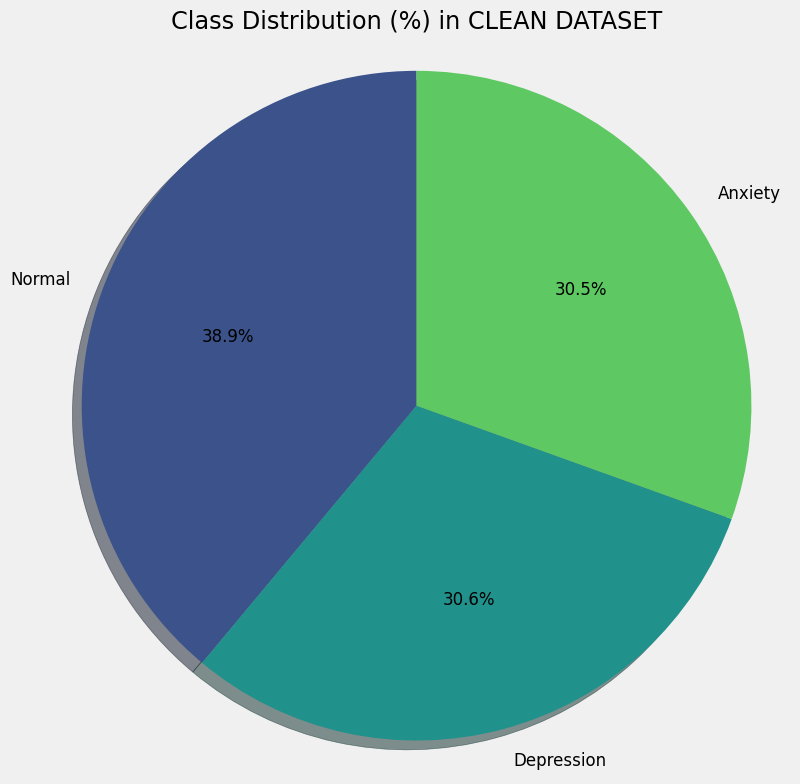


--------------------------------------------------
RAW DATASET
--------------------------------------------------
Class distribution:
label
Normal        1050
Depression     802
Anxiety        801
Name: count, dtype: int64

Percentage distribution:
Normal: 39.58%
Depression: 30.23%
Anxiety: 30.19%


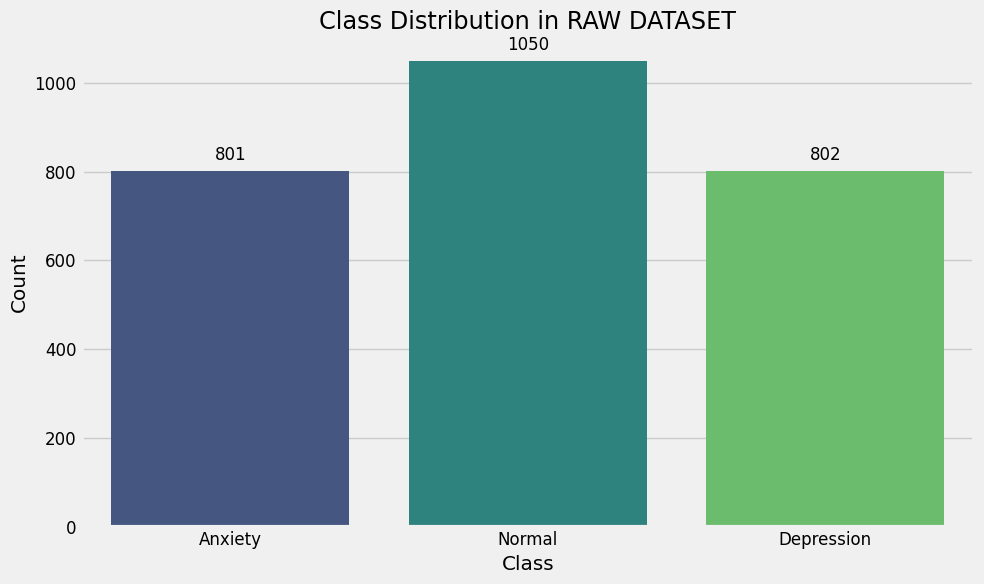

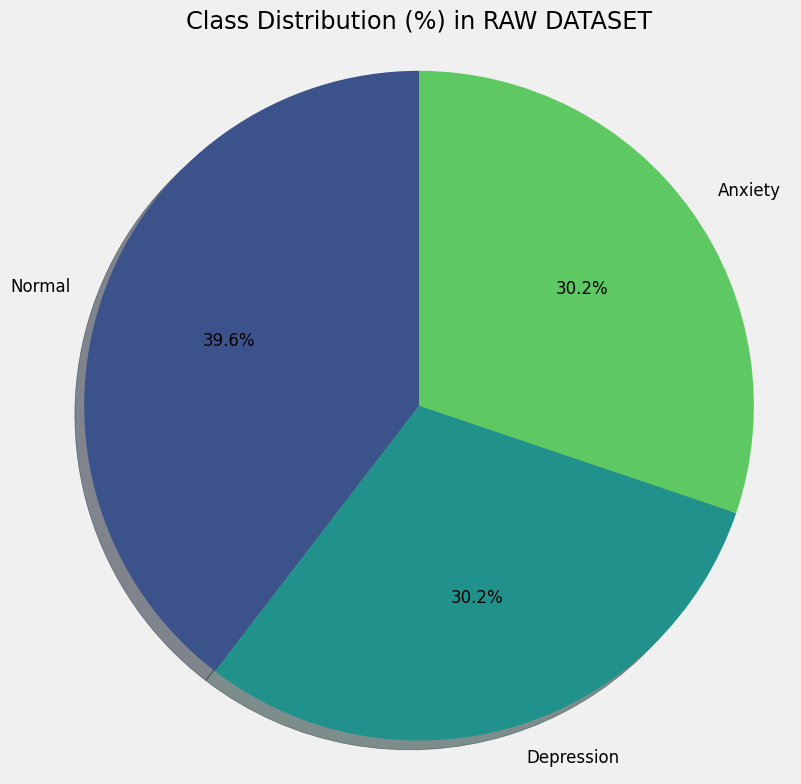

In [5]:
# --------------------------------
# Class distribution analysis
# --------------------------------

def analyze_class_distribution(df, title, label_col='label'):
    """Analyze and visualize the distribution of classes"""
    print(f"\n{'-'*50}")
    print(f"{title}")
    print(f"{'-'*50}")
    
    if df is None or label_col not in df.columns:
        print(f"Label column '{label_col}' not found or dataset not available")
        return
    
    # Count of each class
    class_counts = df[label_col].value_counts()
    print("Class distribution:")
    print(class_counts)
    
    # Percentage distribution
    class_percentages = df[label_col].value_counts(normalize=True) * 100
    print("\nPercentage distribution:")
    for cls, pct in class_percentages.items():
        print(f"{cls}: {pct:.2f}%")
    
    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=label_col, data=df, palette='viridis')
    plt.title(f'Class Distribution in {title}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    
    # Add count labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom', 
                   xytext = (0, 5), textcoords = 'offset points')
    
    plt.tight_layout()
    plt.show()
    
    # Pie chart for class distribution
    plt.figure(figsize=(8, 8))
    plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', 
            startangle=90, shadow=True, colors=sns.color_palette('viridis', len(class_counts)))
    plt.axis('equal')
    plt.title(f'Class Distribution (%) in {title}')
    plt.tight_layout()
    plt.show()

# Analyze class distribution for both datasets
if clean_df is not None:
    analyze_class_distribution(clean_df, "CLEAN DATASET", 'label')
if raw_df is not None:
    analyze_class_distribution(raw_df, "RAW DATASET", 'label')


--------------------------------------------------
CLEAN DATASET - TEXT LENGTH ANALYSIS
--------------------------------------------------
Text length statistics:
       raw_text_char_count  raw_text_word_count  clean_text_char_count  \
count          2617.000000          2617.000000            2617.000000   
mean            289.198701            49.839129             215.053496   
std             277.283790            48.230648             203.696034   
min              25.000000             6.000000               4.000000   
25%              97.000000            17.000000              74.000000   
50%             205.000000            35.000000             158.000000   
75%             369.000000            64.000000             270.000000   
max            3107.000000           530.000000            2196.000000   

       clean_text_word_count  
count            2617.000000  
mean               34.211693  
std                32.068511  
min                 1.000000  
25%           

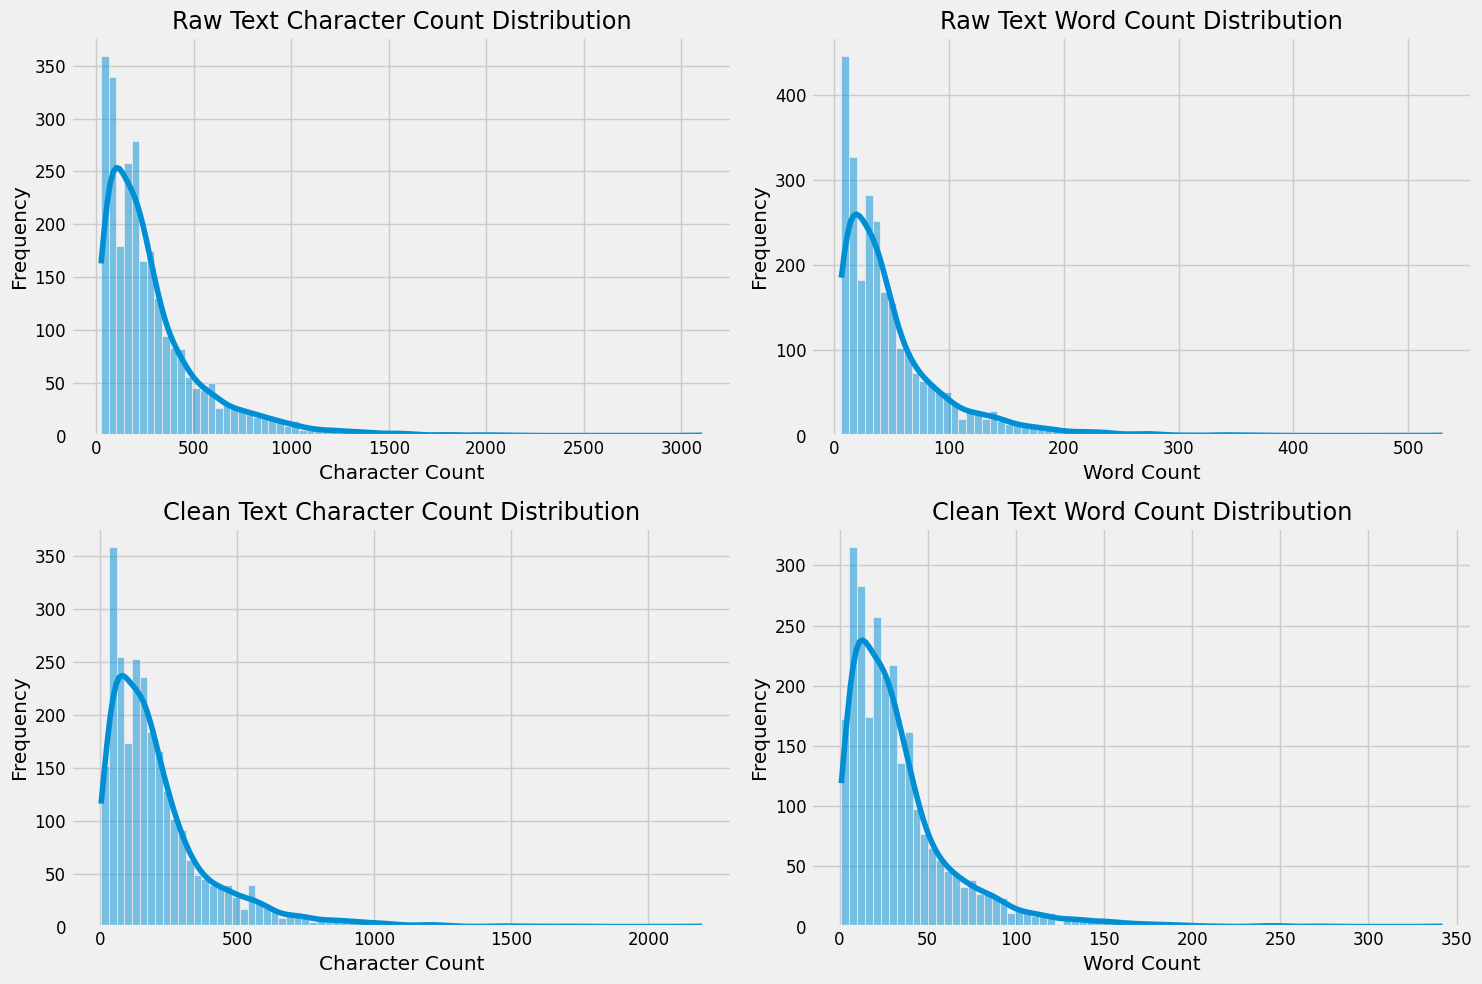

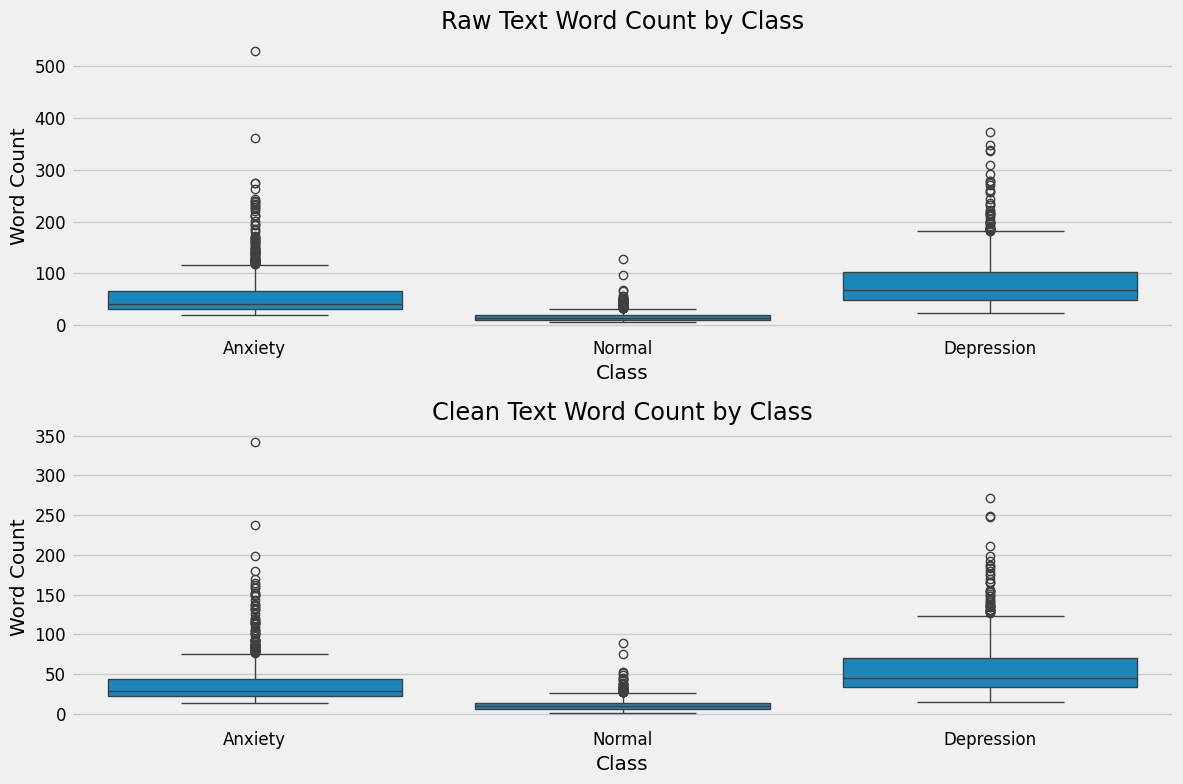

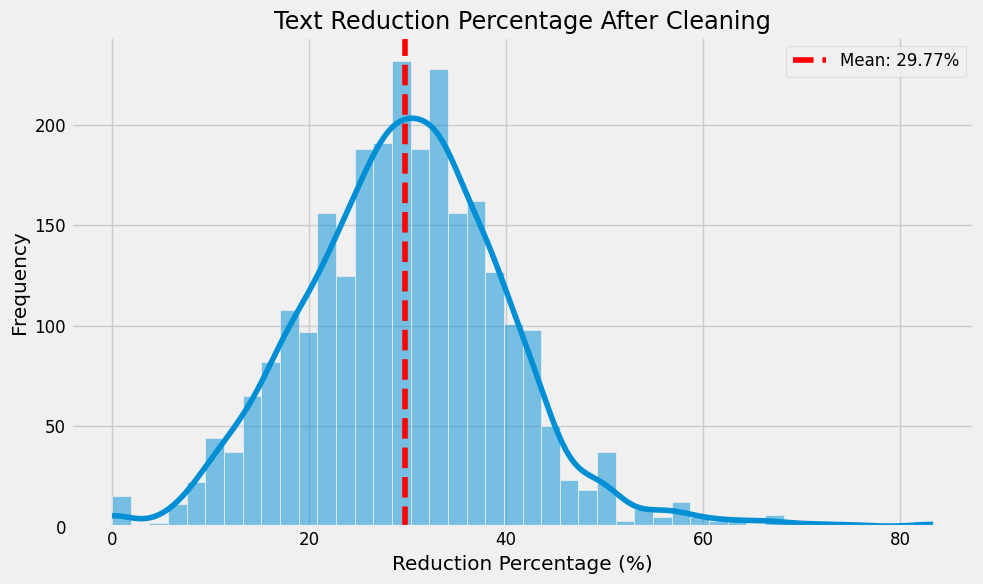


Average text reduction after cleaning: 29.77%
Median text reduction after cleaning: 29.87%

--------------------------------------------------
RAW DATASET - TEXT LENGTH ANALYSIS
--------------------------------------------------
Text length statistics:
       raw_text_char_count  raw_text_word_count
count           2653.00000          2653.000000
mean             286.95703            49.437618
std              276.45657            48.089812
min               25.00000             6.000000
25%               95.00000            16.000000
50%              203.00000            35.000000
75%              366.00000            63.000000
max             3107.00000           530.000000


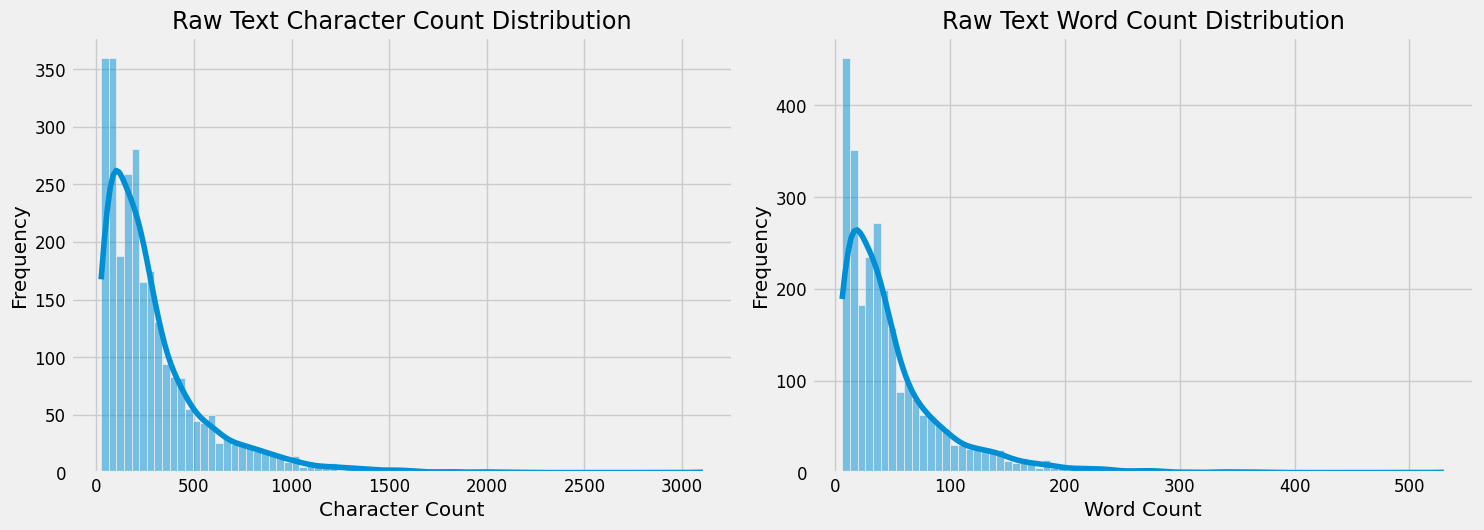

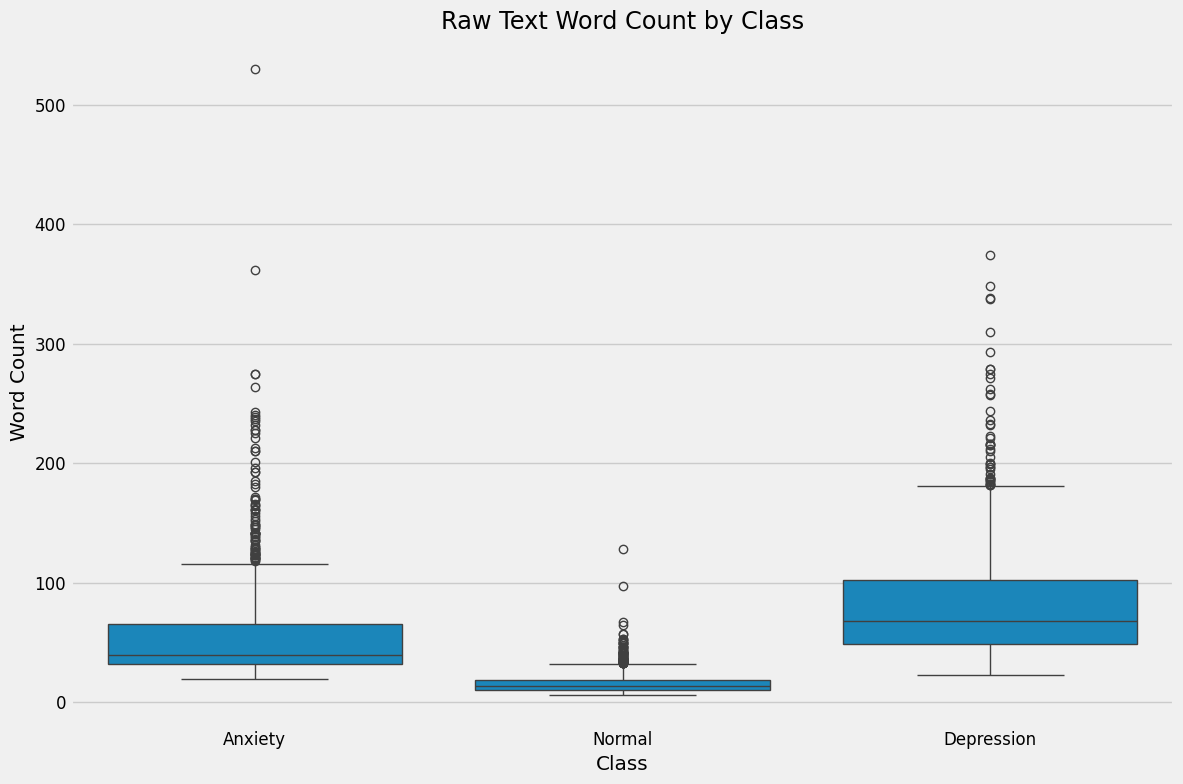

In [6]:
# --------------------------------
# Text Length Analysis
# --------------------------------

def analyze_text_length(df, title, raw_col='raw_text', clean_col='cleaned_text'):
    """Analyze the text length distribution of raw and cleaned text"""
    print(f"\n{'-'*50}")
    print(f"{title} - TEXT LENGTH ANALYSIS")
    print(f"{'-'*50}")
    
    if df is None:
        print("Dataset not available for analysis")
        return
    
    # Check which columns are available
    raw_available = raw_col in df.columns
    clean_available = clean_col in df.columns
    
    if not raw_available and not clean_available:
        print(f"Neither '{raw_col}' nor '{clean_col}' columns found in the dataset")
        return
    
    # Create DataFrames for analysis
    columns_to_extract = ['label']
    if raw_available:
        # Add character and word counts for raw text
        df['raw_text_char_count'] = df[raw_col].fillna('').apply(len)
        df['raw_text_word_count'] = df[raw_col].fillna('').apply(lambda x: len(str(x).split()))
        columns_to_extract.extend(['raw_text_char_count', 'raw_text_word_count'])
        
    if clean_available:
        # Add character and word counts for cleaned text
        df['clean_text_char_count'] = df[clean_col].fillna('').apply(len)
        df['clean_text_word_count'] = df[clean_col].fillna('').apply(lambda x: len(str(x).split()))
        columns_to_extract.extend(['clean_text_char_count', 'clean_text_word_count'])
    
    # Extract the analysis columns
    analysis_df = df[columns_to_extract]
    
    # Display basic statistics
    print("Text length statistics:")
    print(analysis_df.describe())
    
    # Create visualizations for text length distribution
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 2)
    
    # Character count distributions
    if raw_available:
        ax1 = plt.subplot(gs[0, 0])
        sns.histplot(data=df, x='raw_text_char_count', kde=True, ax=ax1)
        ax1.set_title('Raw Text Character Count Distribution')
        ax1.set_xlabel('Character Count')
        ax1.set_ylabel('Frequency')
        
        # Word count distributions
        ax2 = plt.subplot(gs[0, 1])
        sns.histplot(data=df, x='raw_text_word_count', kde=True, ax=ax2)
        ax2.set_title('Raw Text Word Count Distribution')
        ax2.set_xlabel('Word Count')
        ax2.set_ylabel('Frequency')
    
    if clean_available:
        ax3 = plt.subplot(gs[1, 0])
        sns.histplot(data=df, x='clean_text_char_count', kde=True, ax=ax3)
        ax3.set_title('Clean Text Character Count Distribution')
        ax3.set_xlabel('Character Count')
        ax3.set_ylabel('Frequency')
        
        ax4 = plt.subplot(gs[1, 1])
        sns.histplot(data=df, x='clean_text_word_count', kde=True, ax=ax4)
        ax4.set_title('Clean Text Word Count Distribution')
        ax4.set_xlabel('Word Count')
        ax4.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Create box plots to compare text length across classes
    plt.figure(figsize=(12, 8))
    
    if raw_available and clean_available:
        plt.subplot(2, 1, 1)
        sns.boxplot(x='label', y='raw_text_word_count', data=df)
        plt.title('Raw Text Word Count by Class')
        plt.xlabel('Class')
        plt.ylabel('Word Count')
        
        plt.subplot(2, 1, 2)
        sns.boxplot(x='label', y='clean_text_word_count', data=df)
        plt.title('Clean Text Word Count by Class')
        plt.xlabel('Class')
        plt.ylabel('Word Count')
    elif raw_available:
        sns.boxplot(x='label', y='raw_text_word_count', data=df)
        plt.title('Raw Text Word Count by Class')
        plt.xlabel('Class')
        plt.ylabel('Word Count')
    elif clean_available:
        sns.boxplot(x='label', y='clean_text_word_count', data=df)
        plt.title('Clean Text Word Count by Class')
        plt.xlabel('Class')
        plt.ylabel('Word Count')
    
    plt.tight_layout()
    plt.show()
    
    # Compare text reduction after cleaning (if both columns are available)
    if raw_available and clean_available:
        df['text_reduction_pct'] = ((df['raw_text_word_count'] - df['clean_text_word_count']) / 
                                      df['raw_text_word_count'] * 100)
        
        plt.figure(figsize=(10, 6))
        sns.histplot(data=df, x='text_reduction_pct', kde=True)
        plt.title('Text Reduction Percentage After Cleaning')
        plt.xlabel('Reduction Percentage (%)')
        plt.ylabel('Frequency')
        plt.axvline(df['text_reduction_pct'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df["text_reduction_pct"].mean():.2f}%')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"\nAverage text reduction after cleaning: {df['text_reduction_pct'].mean():.2f}%")
        print(f"Median text reduction after cleaning: {df['text_reduction_pct'].median():.2f}%")

# Analyze text length for both datasets
if clean_df is not None:
    text_cols = [col for col in clean_df.columns if 'text' in col.lower()]
    if 'raw_text' in text_cols and 'cleaned_text' in text_cols:
        analyze_text_length(clean_df, "CLEAN DATASET", 'raw_text', 'cleaned_text')
    elif 'cleaned_text' in text_cols:
        analyze_text_length(clean_df, "CLEAN DATASET", clean_col='cleaned_text')

if raw_df is not None:
    text_cols = [col for col in raw_df.columns if 'text' in col.lower()]
    if 'raw_text' in text_cols:
        analyze_text_length(raw_df, "RAW DATASET", 'raw_text')

In [18]:
def analyze_word_frequencies_text_only(df, title, text_col, label_col='label', top_n=20):
    """Analyze the most frequent words in the dataset, overall and by class (text output only)"""
    print(f"\n{'-'*50}")
    print(f"{title} - WORD FREQUENCY ANALYSIS for '{text_col}'")
    print(f"{'-'*50}")
    
    if df is None or text_col not in df.columns:
        print(f"Text column '{text_col}' not found or dataset not available")
        return
        
    # Create function to extract words from text
    def get_words(text):
        if not isinstance(text, str):
            return []
        return str(text).split()
    
    # Get all words from the dataset
    all_words = []
    for text in df[text_col]:
        all_words.extend(get_words(text))
    
    # Count word frequencies
    word_counts = Counter(all_words)
    
    # Get the most common words
    most_common_words = word_counts.most_common(top_n)
    
    print(f"Top {top_n} most frequent words in {text_col}:")
    print(f"{'WORD':<25} {'COUNT':<10}")
    print(f"{'-'*25} {'-'*10}")
    for word, count in most_common_words:
        print(f"{word:<25} {count:<10}")
    
    # Analyze word frequency by class
    if label_col in df.columns:
        # Get unique classes
        classes = df[label_col].unique()
        
        for cls in classes:
            print(f"\n{'-'*30}")
            print(f"Class: {cls}")
            print(f"{'-'*30}")
            
            # Get texts for this class
            class_texts = df[df[label_col] == cls][text_col]
            
            # Get all words for this class
            class_words = []
            for text in class_texts:
                class_words.extend(get_words(text))
            
            # Count word frequencies for this class
            class_word_counts = Counter(class_words)
            
            # Get the most common words for this class
            class_most_common = class_word_counts.most_common(top_n)
            
            if len(class_most_common) > 0:
                print(f"Top {top_n} words for Class {cls}:")
                print(f"{'WORD':<25} {'COUNT':<10}")
                print(f"{'-'*25} {'-'*10}")
                for word, count in class_most_common:
                    print(f"{word:<25} {count:<10}")
            else:
                print(f"No data available for class {cls}")

# Load your dataset
try:
    # Try to load the preprocessed dataset
    clean_df = pd.read_csv("../Data/Preprocessed_Manual_Labelled_Dataset .csv")
    print("Successfully loaded cleaned dataset")
    
    # Run word frequency analysis with text-only output
    if 'cleaned_text' in clean_df.columns:
        analyze_word_frequencies_text_only(clean_df, "CLEAN DATASET", 'cleaned_text')
    else:
        print("No 'cleaned_text' column found in the dataset")
        
    # Also analyze raw text if available
    if 'raw_text' in clean_df.columns:
        analyze_word_frequencies_text_only(clean_df, "CLEAN DATASET", 'raw_text')
    
except FileNotFoundError:
    print("Dataset file not found. Please check the path.")

Successfully loaded cleaned dataset

--------------------------------------------------
CLEAN DATASET - WORD FREQUENCY ANALYSIS for 'cleaned_text'
--------------------------------------------------
Top 20 most frequent words in cleaned_text:
WORD                      COUNT     
------------------------- ----------
වෙලා                      1071      
වෙනවා                     883       
මාව                       592       
දැනෙනවා                   573       
බැහැ                      541       
කතා                       497       
හැම                       480       
ඉන්න                      456       
එය                        441       
බැරි                      439       
හිතෙනවා                   425       
තියෙනවා                   392       
වැඩ                       392       
ඉන්නවා                    365       
ඒත්                       364       
කිසිම                     357       
මොකද                      327       
තරම්                      325       
විතරයි            


--------------------------------------------------
CLEAN DATASET - TEXT COMPLEXITY ANALYSIS for 'cleaned_text'
--------------------------------------------------
Text complexity statistics:
       unique_words_ratio  avg_word_length
count         2617.000000      2617.000000
mean             0.938742         5.308722
std              0.067501         0.565548
min              0.548387         3.000000
25%              0.896552         5.000000
50%              0.954545         5.282051
75%              1.000000         5.600000
max              1.000000        10.000000


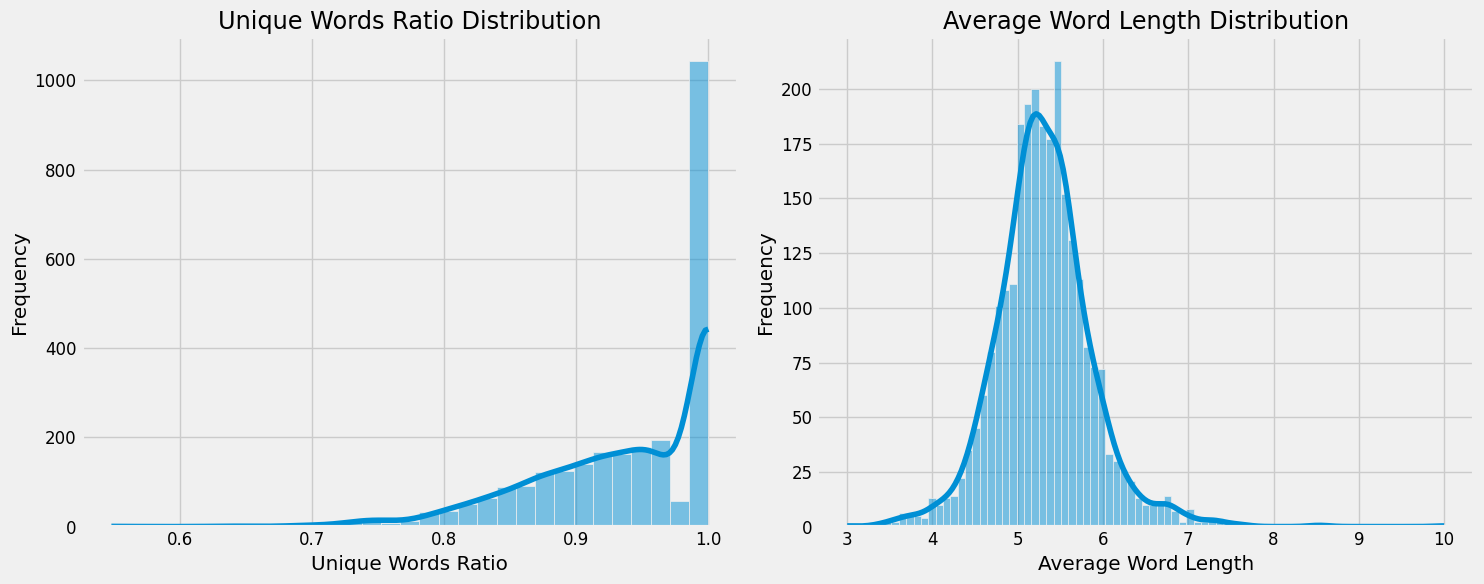

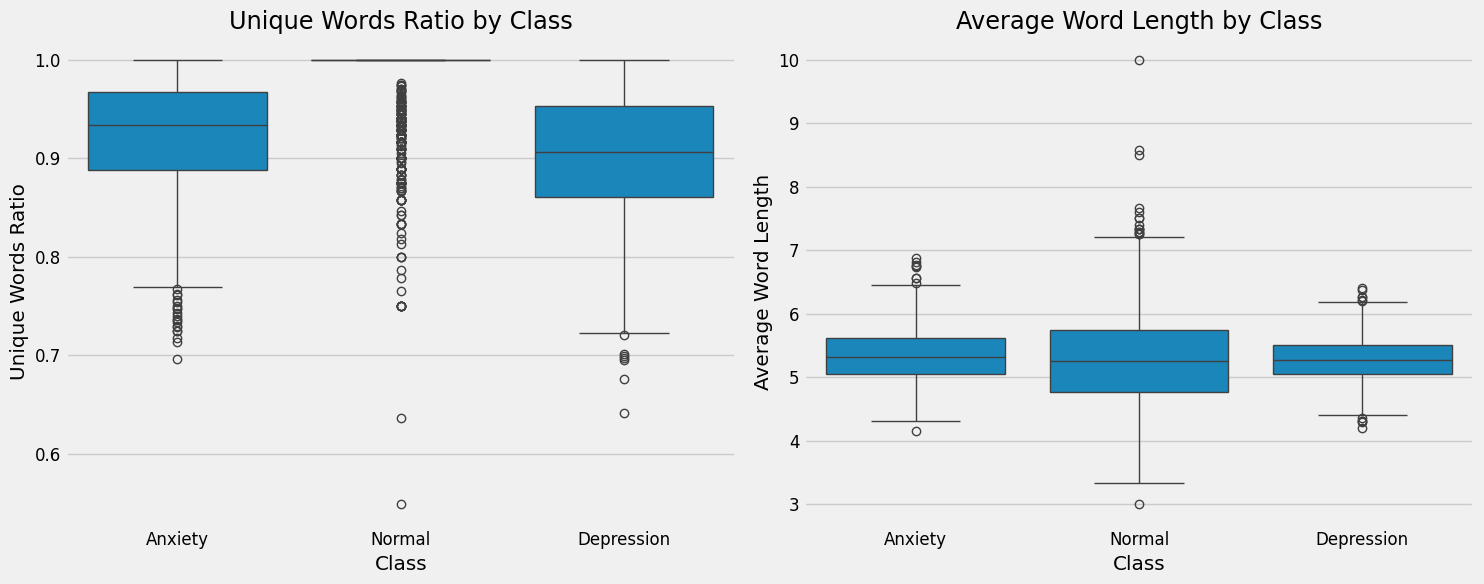


--------------------------------------------------
CLEAN DATASET - TEXT COMPLEXITY ANALYSIS for 'raw_text'
--------------------------------------------------
Text complexity statistics:
       unique_words_ratio  avg_word_length
count         2617.000000      2617.000000
mean             0.900973         4.846649
std              0.096212         0.455250
min              0.541436         3.166667
25%              0.836735         4.576471
50%              0.923077         4.833333
75%              1.000000         5.088608
max              1.000000         8.833333


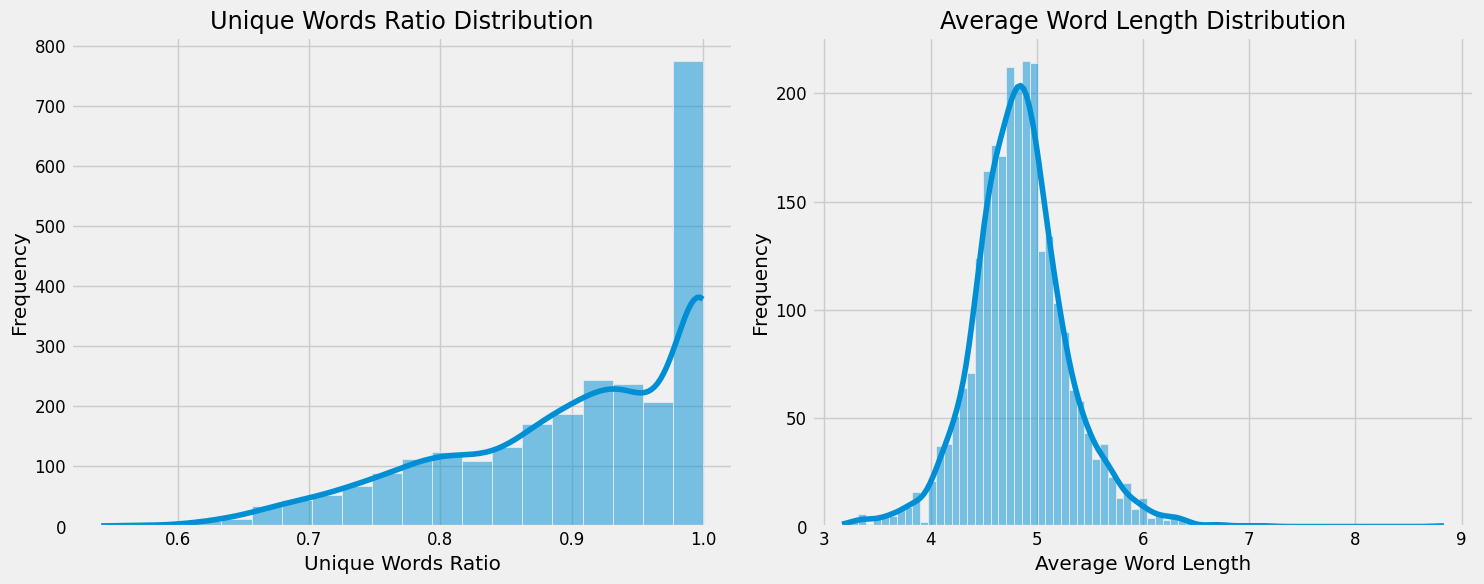

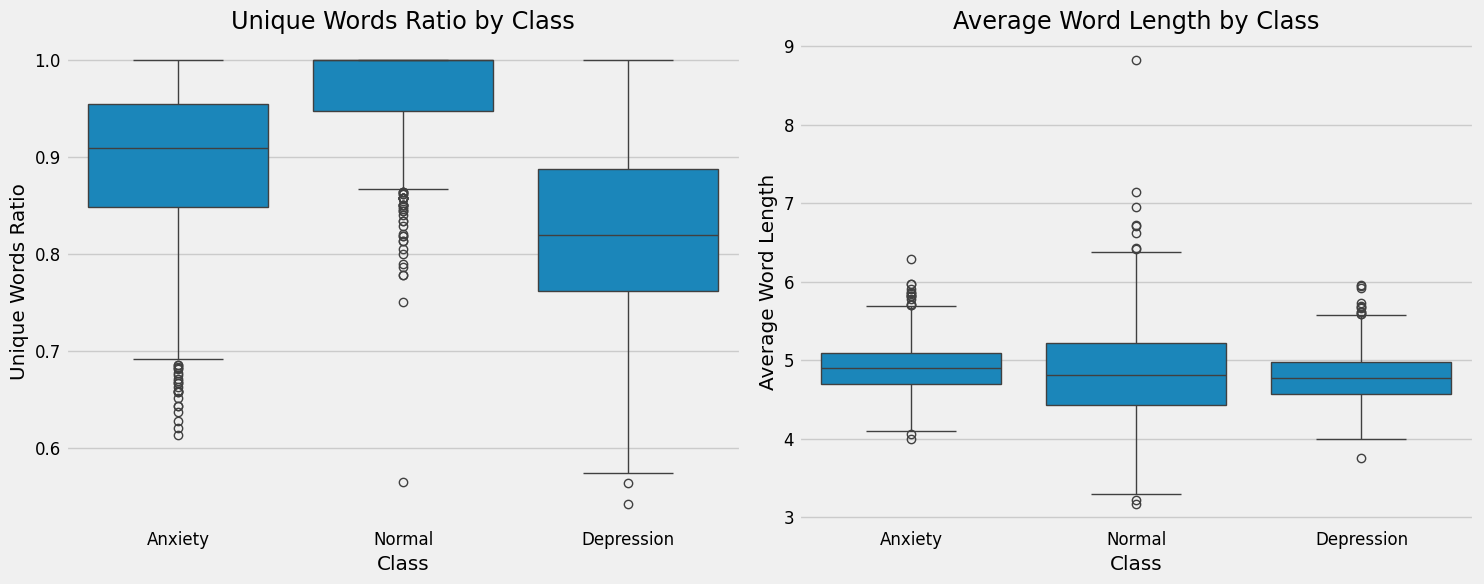


--------------------------------------------------
RAW DATASET - TEXT COMPLEXITY ANALYSIS for 'raw_text'
--------------------------------------------------
Text complexity statistics:
       unique_words_ratio  avg_word_length
count         2653.000000      2653.000000
mean             0.901983         4.851930
std              0.096131         0.457321
min              0.541436         3.166667
25%              0.839506         4.579710
50%              0.923077         4.833333
75%              1.000000         5.093750
max              1.000000         8.833333


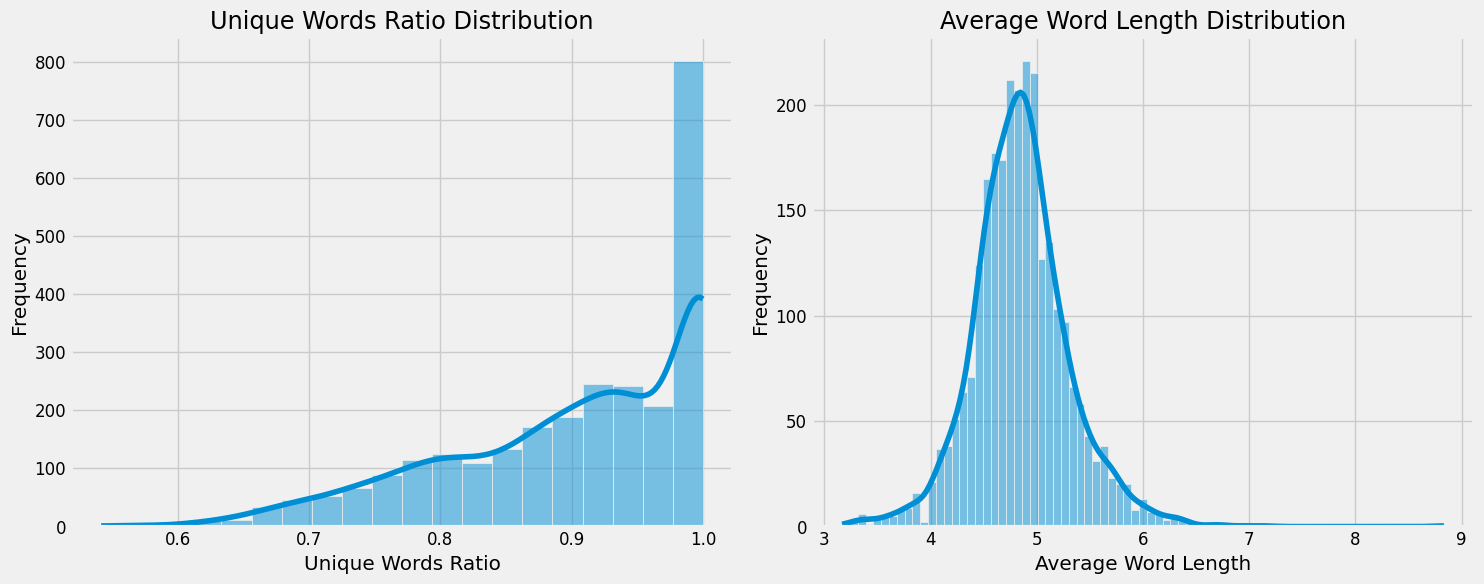

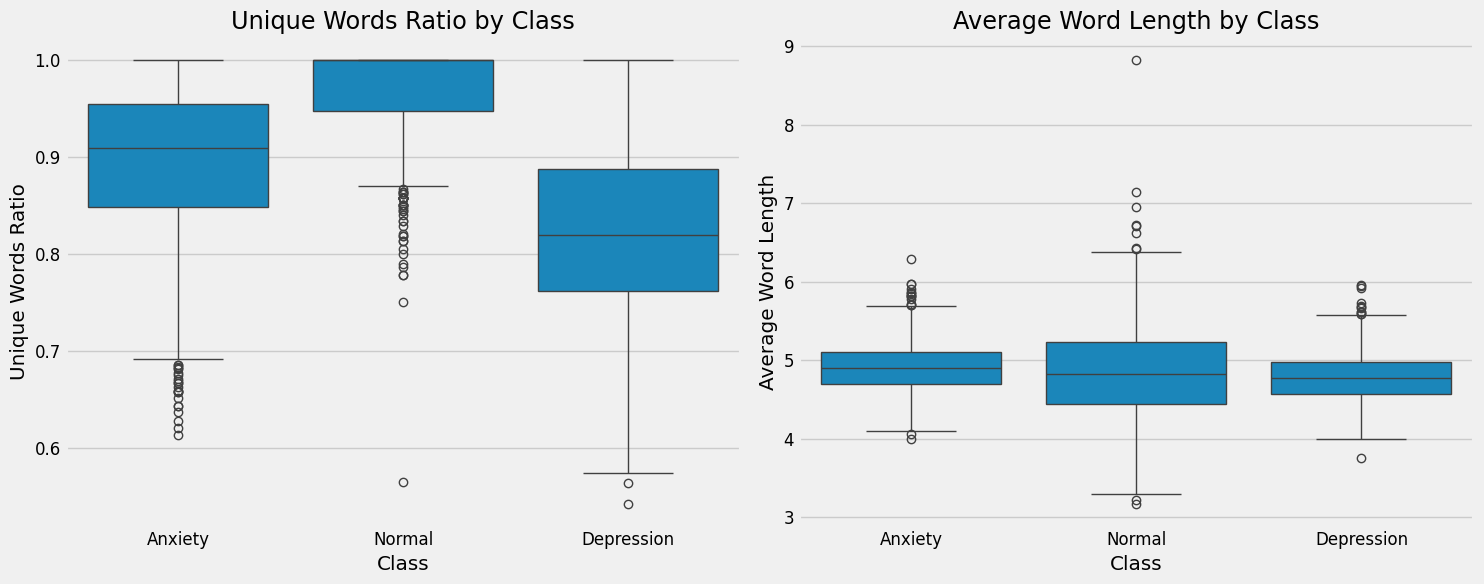

In [19]:
# --------------------------------
# Text Complexity Analysis
# --------------------------------

def analyze_text_complexity(df, title, text_col):
    """Analyze text complexity metrics: unique words ratio, avg word length"""
    print(f"\n{'-'*50}")
    print(f"{title} - TEXT COMPLEXITY ANALYSIS for '{text_col}'")
    print(f"{'-'*50}")
    
    if df is None or text_col not in df.columns:
        print(f"Text column '{text_col}' not found or dataset not available")
        return
    
    # Calculate complexity metrics
    def calculate_metrics(text):
        if not isinstance(text, str) or len(text) == 0:
            return 0, 0
        
        # Tokenize the text
        words = text.split()
        
        if len(words) == 0:
            return 0, 0
        
        # Calculate metrics
        unique_words_ratio = len(set(words)) / len(words)
        avg_word_length = sum(len(word) for word in words) / len(words)
        
        return unique_words_ratio, avg_word_length
    
    # Apply the function to the text column
    metrics = df[text_col].apply(calculate_metrics)
    df['unique_words_ratio'] = metrics.apply(lambda x: x[0])
    df['avg_word_length'] = metrics.apply(lambda x: x[1])
    
    # Display basic statistics
    print("Text complexity statistics:")
    print(df[['unique_words_ratio', 'avg_word_length']].describe())
    
    # Create visualizations
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Unique words ratio distribution
    sns.histplot(data=df, x='unique_words_ratio', kde=True, ax=axes[0])
    axes[0].set_title('Unique Words Ratio Distribution')
    axes[0].set_xlabel('Unique Words Ratio')
    axes[0].set_ylabel('Frequency')
    
    # Average word length distribution
    sns.histplot(data=df, x='avg_word_length', kde=True, ax=axes[1])
    axes[1].set_title('Average Word Length Distribution')
    axes[1].set_xlabel('Average Word Length')
    axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Check if label column exists
    if 'label' in df.columns:
        # Create box plots to compare complexity metrics across classes
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        sns.boxplot(x='label', y='unique_words_ratio', data=df, ax=axes[0])
        axes[0].set_title('Unique Words Ratio by Class')
        axes[0].set_xlabel('Class')
        axes[0].set_ylabel('Unique Words Ratio')
        
        sns.boxplot(x='label', y='avg_word_length', data=df, ax=axes[1])
        axes[1].set_title('Average Word Length by Class')
        axes[1].set_xlabel('Class')
        axes[1].set_ylabel('Average Word Length')
        
        plt.tight_layout()
        plt.show()

# Analyze text complexity for both datasets
if clean_df is not None:
    if 'cleaned_text' in clean_df.columns:
        analyze_text_complexity(clean_df, "CLEAN DATASET", 'cleaned_text')
    if 'raw_text' in clean_df.columns:
        analyze_text_complexity(clean_df, "CLEAN DATASET", 'raw_text')

if raw_df is not None:
    if 'raw_text' in raw_df.columns:
        analyze_text_complexity(raw_df, "RAW DATASET", 'raw_text')


--------------------------------------------------
COMPARATIVE ANALYSIS: RAW vs CLEANED DATASETS
--------------------------------------------------
Raw dataset size: (2653, 6)
Clean dataset size: (2617, 11)


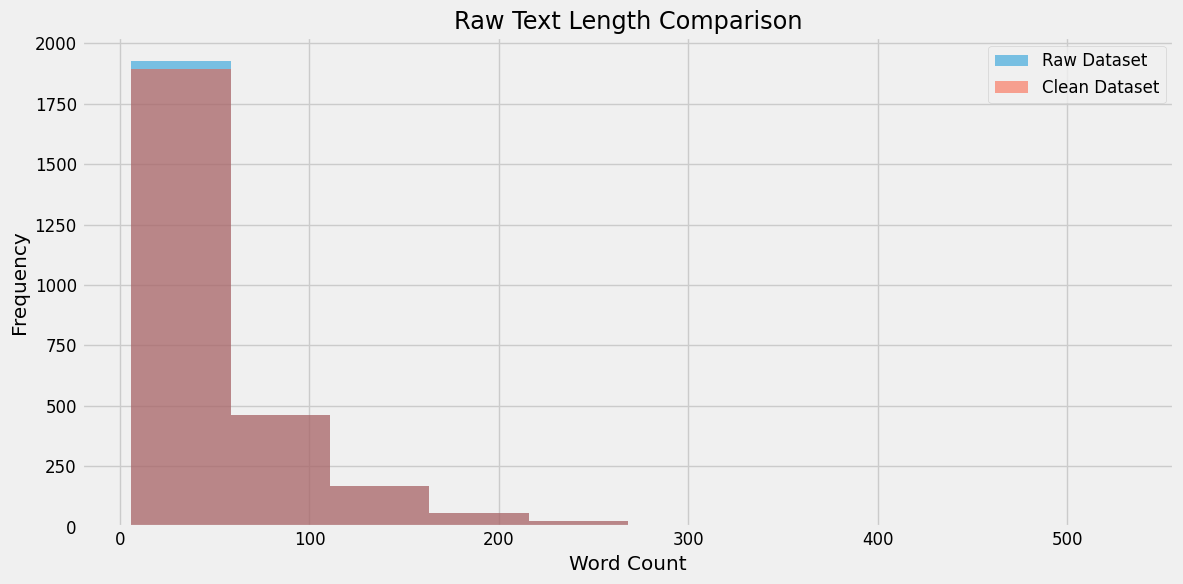

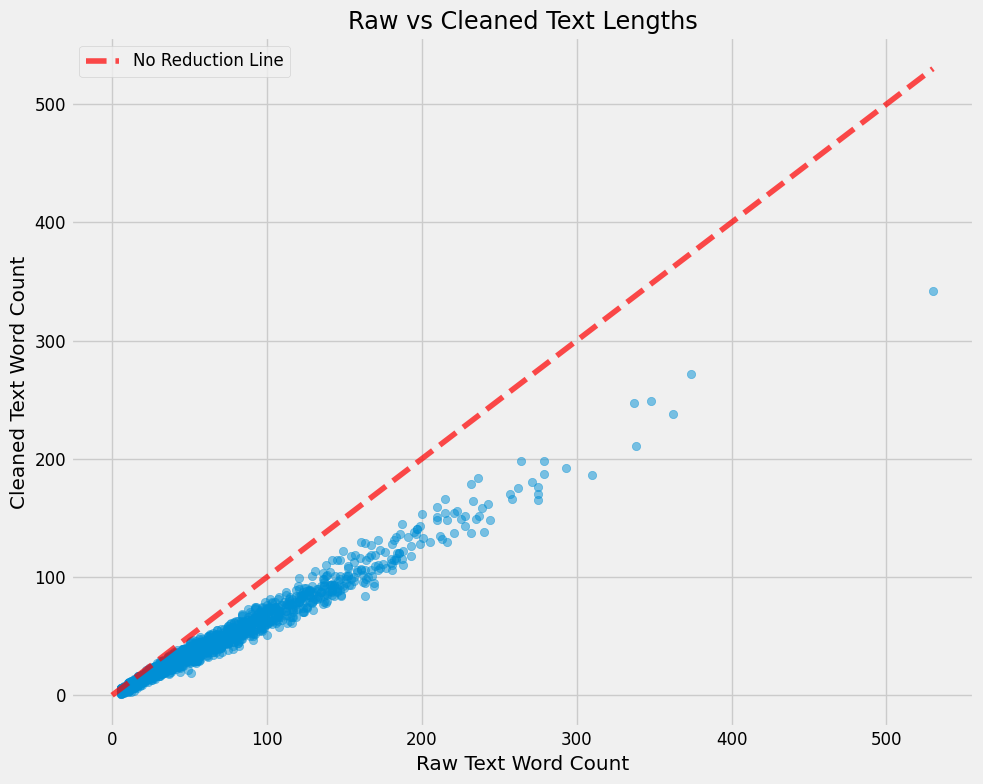

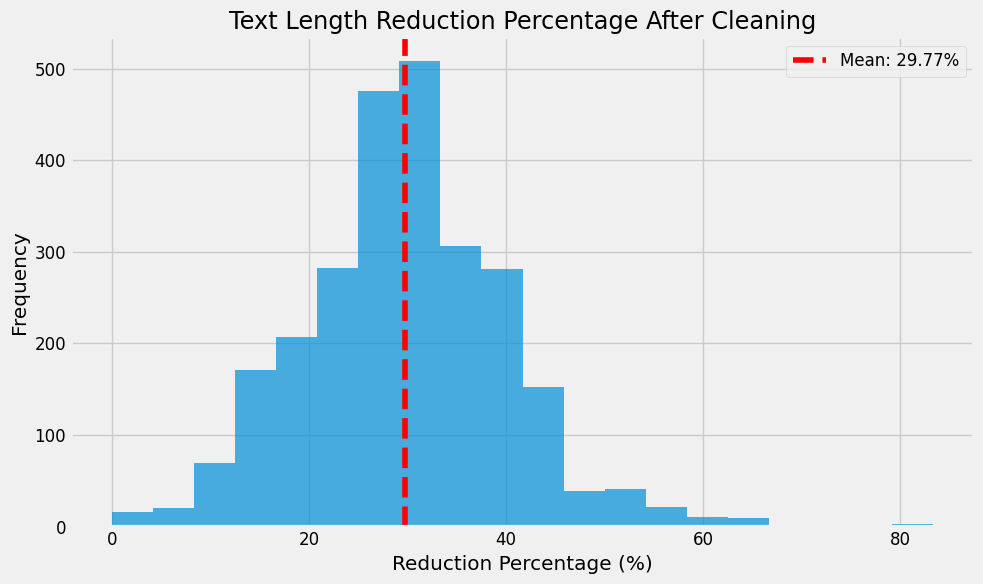


Text length reduction statistics:
       length_reduction  length_reduction_pct
count       2617.000000           2617.000000
mean          15.627436             29.771459
std           17.091807             10.357423
min            0.000000              0.000000
25%            5.000000             23.076923
50%            9.000000             29.870130
75%           20.000000             36.170213
max          188.000000             83.333333


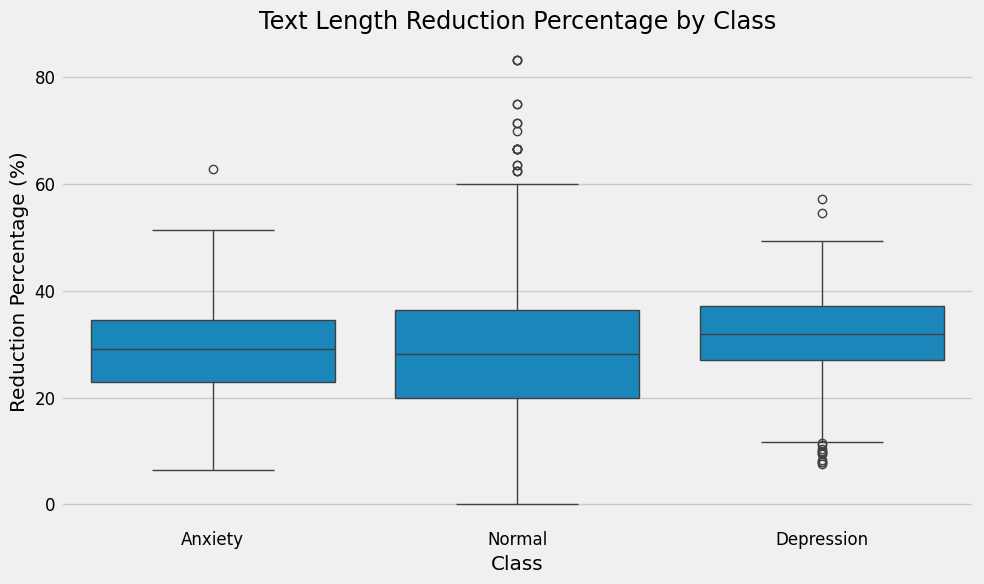

In [21]:
# --------------------------------
# Comparative Analysis 
# --------------------------------

def compare_datasets(raw_df, clean_df):
    """Compare the raw and cleaned datasets"""
    print(f"\n{'-'*50}")
    print("COMPARATIVE ANALYSIS: RAW vs CLEANED DATASETS")
    print(f"{'-'*50}")
    
    if raw_df is None or clean_df is None:
        print("Both datasets are required for comparative analysis")
        return
    
    # Compare dataset sizes
    print(f"Raw dataset size: {raw_df.shape}")
    print(f"Clean dataset size: {clean_df.shape}")
    
    # Check if both datasets have raw_text column
    if 'raw_text' in raw_df.columns and 'raw_text' in clean_df.columns:
        # Compare text length distributions
        raw_text_lengths = raw_df['raw_text'].apply(lambda x: len(str(x).split()))
        clean_text_lengths = clean_df['raw_text'].apply(lambda x: len(str(x).split()))
        
        plt.figure(figsize=(12, 6))
        plt.hist(raw_text_lengths, alpha=0.5, label='Raw Dataset')
        plt.hist(clean_text_lengths, alpha=0.5, label='Clean Dataset')
        plt.title('Raw Text Length Comparison')
        plt.xlabel('Word Count')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # Check if clean dataset has both raw and cleaned text
    if 'raw_text' in clean_df.columns and 'cleaned_text' in clean_df.columns:
        # Compare raw vs cleaned text lengths
        clean_df['raw_length'] = clean_df['raw_text'].apply(lambda x: len(str(x).split()))
        clean_df['cleaned_length'] = clean_df['cleaned_text'].apply(lambda x: len(str(x).split()))
        clean_df['length_reduction'] = clean_df['raw_length'] - clean_df['cleaned_length']
        clean_df['length_reduction_pct'] = (clean_df['length_reduction'] / clean_df['raw_length']) * 100
        
        # Scatter plot of raw vs cleaned text lengths
        plt.figure(figsize=(10, 8))
        plt.scatter(clean_df['raw_length'], clean_df['cleaned_length'], alpha=0.5)
        plt.plot([0, max(clean_df['raw_length'])], [0, max(clean_df['raw_length'])], 'r--', 
                alpha=0.7, label='No Reduction Line')
        plt.title('Raw vs Cleaned Text Lengths')
        plt.xlabel('Raw Text Word Count')
        plt.ylabel('Cleaned Text Word Count')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Histogram of length reduction percentage
        plt.figure(figsize=(10, 6))
        plt.hist(clean_df['length_reduction_pct'], bins=20, alpha=0.7)
        plt.axvline(clean_df['length_reduction_pct'].mean(), color='r', linestyle='--', 
                   label=f'Mean: {clean_df["length_reduction_pct"].mean():.2f}%')
        plt.title('Text Length Reduction Percentage After Cleaning')
        plt.xlabel('Reduction Percentage (%)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Summary statistics
        print("\nText length reduction statistics:")
        print(clean_df[['length_reduction', 'length_reduction_pct']].describe())
        
        # Compare by class if available
        if 'label' in clean_df.columns:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x='label', y='length_reduction_pct', data=clean_df)
            plt.title('Text Length Reduction Percentage by Class')
            plt.xlabel('Class')
            plt.ylabel('Reduction Percentage (%)')
            plt.tight_layout()
            plt.show()

# Comparative analysis if both datasets are available
if raw_df is not None and clean_df is not None:
    compare_datasets(raw_df, clean_df)


In [22]:
# --------------------------------
# Summary of findings
# --------------------------------

print(f"\n{'-'*50}")
print("SUMMARY OF EDA FINDINGS")
print(f"{'-'*50}")

# Class distribution summary
if clean_df is not None and 'label' in clean_df.columns:
    print("\nClass Distribution Summary:")
    class_counts = clean_df['label'].value_counts()
    for cls, count in class_counts.items():
        print(f"  - {cls}: {count} samples ({count/len(clean_df)*100:.2f}%)")

# Text length summary
if clean_df is not None:
    if 'cleaned_text' in clean_df.columns:
        clean_df['word_count'] = clean_df['cleaned_text'].apply(lambda x: len(str(x).split()))
        print("\nText Length Summary:")
        print(f"  - Average word count: {clean_df['word_count'].mean():.2f}")
        print(f"  - Median word count: {clean_df['word_count'].median():.0f}")
        print(f"  - Min word count: {clean_df['word_count'].min()}")
        print(f"  - Max word count: {clean_df['word_count'].max()}")

# Cleaning effect summary
if clean_df is not None and 'raw_text' in clean_df.columns and 'cleaned_text' in clean_df.columns:
    clean_df['raw_length'] = clean_df['raw_text'].apply(lambda x: len(str(x).split()))
    clean_df['cleaned_length'] = clean_df['cleaned_text'].apply(lambda x: len(str(x).split()))
    clean_df['length_reduction_pct'] = ((clean_df['raw_length'] - clean_df['cleaned_length']) / 
                                      clean_df['raw_length'] * 100)
    
    print("\nText Cleaning Effect Summary:")
    print(f"  - Average text reduction: {clean_df['length_reduction_pct'].mean():.2f}%")
    print(f"  - Median text reduction: {clean_df['length_reduction_pct'].median():.2f}%")


--------------------------------------------------
SUMMARY OF EDA FINDINGS
--------------------------------------------------

Class Distribution Summary:
  - Normal: 1019 samples (38.94%)
  - Depression: 800 samples (30.57%)
  - Anxiety: 798 samples (30.49%)

Text Length Summary:
  - Average word count: 34.21
  - Median word count: 26
  - Min word count: 1
  - Max word count: 342

Text Cleaning Effect Summary:
  - Average text reduction: 29.77%
  - Median text reduction: 29.87%
